In [1]:
# Celda 1: Imports
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    RocCurveDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"üñ•Ô∏è  Dispositivo: {device}")

c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


üñ•Ô∏è  Dispositivo: cuda


In [2]:
# Celda 2: Configuraci√≥n de los 3 mejores modelos
# üèÜ Los mejores modelos entrenados para cada dataset

models_to_compare = {
    "codigos": {
        "name": "BERT Spanish Cased (C√≥digos)",
        "path": r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-cased_codigos_final",
        "dataset_path": r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\TFG\dataset\diagnosticos_binarios_codigos.csv",
        "target_logic": lambda x: 1 if "F20" in x and "F20.89" not in x else 0,
        "color": "red"
    },
    "descripciones": {
        "name": "BERT Spanish Uncased (Descripciones)", 
        "path": r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-uncased_descripciones_final",
        "dataset_path": r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\TFG\dataset\diagnosticos_binarios_descripciones.csv",
        "target_logic": lambda x: 1 if "Esquizofrenia" in x and "Otros tipos de esquizofrenia" not in x else 0,
        "color": "blue"
    },
    "combinado": {
        "name": "BERT Spanish Cased (Combinado)",
        "path": r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-cased_combinado_final",
        "dataset_path": r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\TFG\dataset\diagnosticos_binarios_combinados.csv", 
        "target_logic": lambda x: 1 if "F20" in x and "F20.89" not in x else 0,
        "color": "green"
    }
}

print("üîß Modelos configurados para comparaci√≥n:")
for dataset_type, config in models_to_compare.items():
    print(f"‚Ä¢ {dataset_type}: {config['name']}")

üîß Modelos configurados para comparaci√≥n:
‚Ä¢ codigos: BERT Spanish Cased (C√≥digos)
‚Ä¢ descripciones: BERT Spanish Uncased (Descripciones)
‚Ä¢ combinado: BERT Spanish Cased (Combinado)


In [3]:
# Celda 3: Funci√≥n para evaluar modelo
def evaluate_model(dataset_type, config):
    """Eval√∫a un modelo en su dataset correspondiente"""
    
    print(f"\nüöÄ Evaluando: {config['name']}")
    
    # Cargar dataset
    df = pd.read_csv(config["dataset_path"], sep="|")
    diag_cols = [col for col in df.columns if col.startswith("Diag")]
    df["text"] = df[diag_cols].fillna("").apply(lambda x: " ".join(x), axis=1)
    df["label"] = df["DIAG PSQ"].apply(config["target_logic"])
    
    # Divisi√≥n de datos (mismo seed para consistencia)
    X_train, X_test, y_train, y_test = train_test_split(
        df["text"], df["label"], 
        stratify=df["label"], 
        test_size=0.2, 
        random_state=42
    )
    
    print(f"üìä Dataset {dataset_type}:")
    print(f"   Total ejemplos: {len(df)}")
    print(f"   Test set: {len(X_test)}")
    print(f"   Distribuci√≥n: {df['label'].value_counts().to_dict()}")
    
    # Cargar modelo
    model = AutoModelForSequenceClassification.from_pretrained(config["path"]).to(device)
    tokenizer = AutoTokenizer.from_pretrained(config["path"])
    
    # Tokenizar
    inputs = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors="pt").to(device)
    
    # Predicci√≥n
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()
    
    y_pred = probs.argmax(axis=1)
    y_proba = probs[:, 1]
    
    # Calcular m√©tricas
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average='binary', zero_division=0),
        "recall": recall_score(y_test, y_pred, average='binary', zero_division=0),
        "f1": f1_score(y_test, y_pred, average='binary', zero_division=0),
        "roc_auc": auc(*roc_curve(y_test, y_proba)[:2])
    }
    
    print(f"‚úÖ M√©tricas {dataset_type}:")
    for metric, value in metrics.items():
        print(f"   {metric.upper()}: {value:.4f}")
    
    return {
        "dataset_type": dataset_type,
        "name": config["name"],
        "color": config["color"],
        "metrics": metrics,
        "y_test": y_test,
        "y_pred": y_pred,
        "y_proba": y_proba
    }

In [4]:
# Celda 4: Evaluar todos los modelos
print("üèÅ Iniciando evaluaci√≥n comparativa...")

results = {}
for dataset_type, config in models_to_compare.items():
    results[dataset_type] = evaluate_model(dataset_type, config)

üèÅ Iniciando evaluaci√≥n comparativa...

üöÄ Evaluando: BERT Spanish Cased (C√≥digos)
üìä Dataset codigos:
   Total ejemplos: 1997
   Test set: 400
   Distribuci√≥n: {0: 1385, 1: 612}
‚úÖ M√©tricas codigos:
   ACCURACY: 0.7550
   PRECISION: 0.5796
   RECALL: 0.7398
   F1: 0.6500
   ROC_AUC: 0.8336

üöÄ Evaluando: BERT Spanish Uncased (Descripciones)
üìä Dataset descripciones:
   Total ejemplos: 1997
   Test set: 400
   Distribuci√≥n: {0: 1394, 1: 603}
‚úÖ M√©tricas descripciones:
   ACCURACY: 0.8875
   PRECISION: 0.8519
   RECALL: 0.7603
   F1: 0.8035
   ROC_AUC: 0.9521

üöÄ Evaluando: BERT Spanish Cased (Combinado)
üìä Dataset combinado:
   Total ejemplos: 1997
   Test set: 400
   Distribuci√≥n: {0: 1385, 1: 612}
‚úÖ M√©tricas combinado:
   ACCURACY: 0.9025
   PRECISION: 0.8043
   RECALL: 0.9024
   F1: 0.8506
   ROC_AUC: 0.9597


In [5]:
# Celda 5: Tabla comparativa de m√©tricas
print("\nüìä TABLA COMPARATIVA DE RESULTADOS")
print("=" * 80)

# Crear DataFrame para comparaci√≥n
comparison_data = []
for dataset_type, result in results.items():
    row = {
        "Modelo": result["name"],
        "Dataset": dataset_type.title(),
        "Accuracy": result["metrics"]["accuracy"],
        "Precision": result["metrics"]["precision"], 
        "Recall": result["metrics"]["recall"],
        "F1-Score": result["metrics"]["f1"],
        "ROC AUC": result["metrics"]["roc_auc"]
    }
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.round(4).to_string(index=False))

# Encontrar mejores resultados
print(f"\nüèÜ MEJORES RESULTADOS:")
print(f"Mejor Accuracy: {comparison_df['Accuracy'].max():.4f} - {comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Modelo']}")
print(f"Mejor Precision: {comparison_df['Precision'].max():.4f} - {comparison_df.loc[comparison_df['Precision'].idxmax(), 'Modelo']}")
print(f"Mejor Recall: {comparison_df['Recall'].max():.4f} - {comparison_df.loc[comparison_df['Recall'].idxmax(), 'Modelo']}")
print(f"Mejor F1-Score: {comparison_df['F1-Score'].max():.4f} - {comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Modelo']}")
print(f"Mejor ROC AUC: {comparison_df['ROC AUC'].max():.4f} - {comparison_df.loc[comparison_df['ROC AUC'].idxmax(), 'Modelo']}")


üìä TABLA COMPARATIVA DE RESULTADOS
                              Modelo       Dataset  Accuracy  Precision  Recall  F1-Score  ROC AUC
        BERT Spanish Cased (C√≥digos)       Codigos    0.7550     0.5796  0.7398    0.6500   0.8336
BERT Spanish Uncased (Descripciones) Descripciones    0.8875     0.8519  0.7603    0.8035   0.9521
      BERT Spanish Cased (Combinado)     Combinado    0.9025     0.8043  0.9024    0.8506   0.9597

üèÜ MEJORES RESULTADOS:
Mejor Accuracy: 0.9025 - BERT Spanish Cased (Combinado)
Mejor Precision: 0.8519 - BERT Spanish Uncased (Descripciones)
Mejor Recall: 0.9024 - BERT Spanish Cased (Combinado)
Mejor F1-Score: 0.8506 - BERT Spanish Cased (Combinado)
Mejor ROC AUC: 0.9597 - BERT Spanish Cased (Combinado)


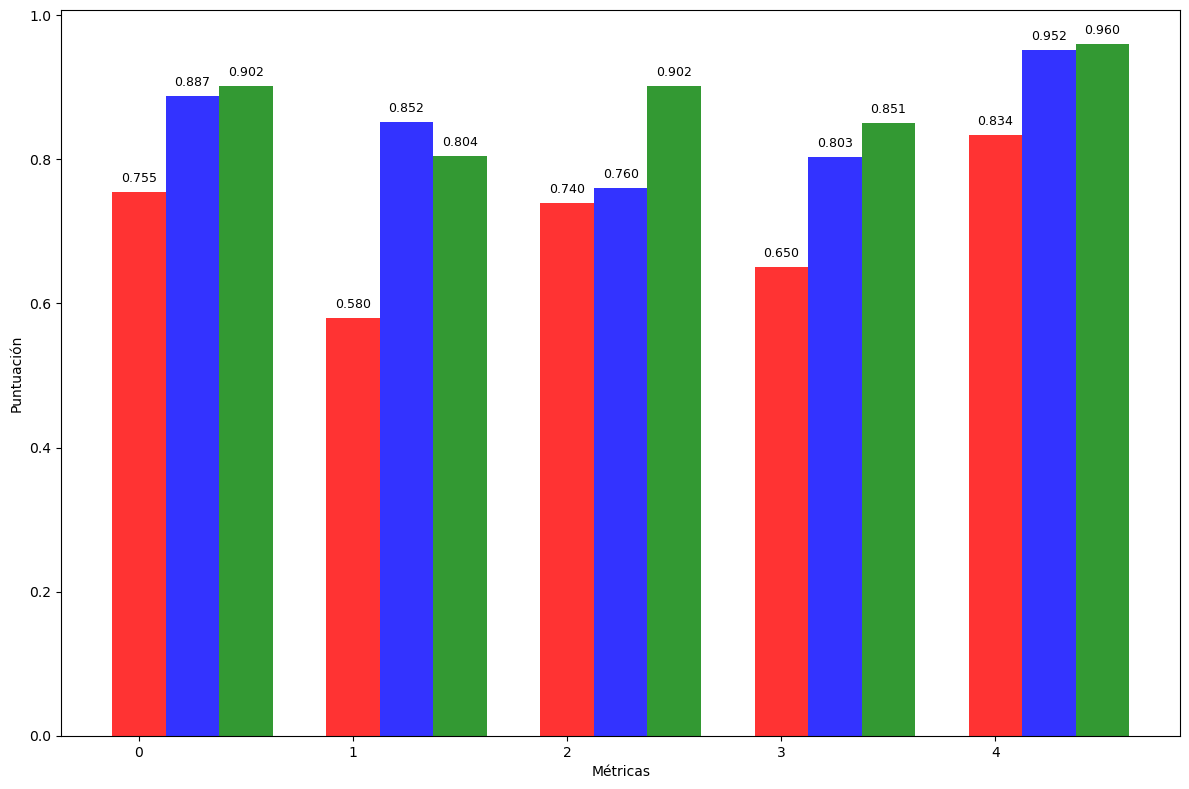

In [6]:
# Celda 6: Gr√°fico comparativo de m√©tricas
fig, ax = plt.subplots(figsize=(12, 8))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
metric_keys = {
    'Accuracy': 'accuracy',
    'Precision': 'precision',
    'Recall': 'recall',
    'F1-Score': 'f1',
    'ROC AUC': 'roc_auc'
}
x = np.arange(len(metrics))
width = 0.25

for i, (dataset_type, result) in enumerate(results.items()):
    values = [result["metrics"][metric_keys[m]] for m in metrics]
    ax.bar(x + i*width, values, width, 
           label=result["name"], 
           color=result["color"], 
           alpha=0.8)

ax.set_xlabel('M√©tricas')
ax.set_ylabel('Puntuaci√≥n')
# A√±adir valores en las barras
for i, (dataset_type, result) in enumerate(results.items()):
    values = [result["metrics"][metric_keys[m]] for m in metrics]
    for j, v in enumerate(values):
        ax.text(j + i*width, v + 0.01, f'{v:.3f}', 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('metricas_comparativas.png', dpi=300)
plt.show()

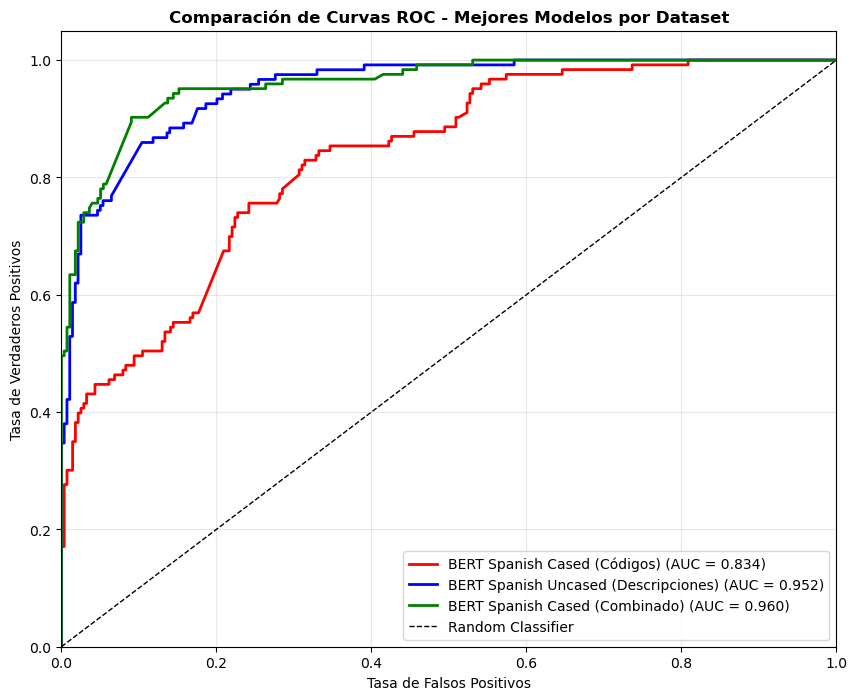

In [7]:
# Celda 7: Curvas ROC comparativas
plt.figure(figsize=(10, 8))

for dataset_type, result in results.items():
    fpr, tpr, _ = roc_curve(result["y_test"], result["y_proba"])
    roc_auc = result["metrics"]["roc_auc"]
    
    plt.plot(fpr, tpr, 
             color=result["color"],
             linewidth=2,
             label=f'{result["name"]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Comparaci√≥n de Curvas ROC - Mejores Modelos por Dataset', fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('curvas_roc_comparativas.png', dpi=300)
plt.show()

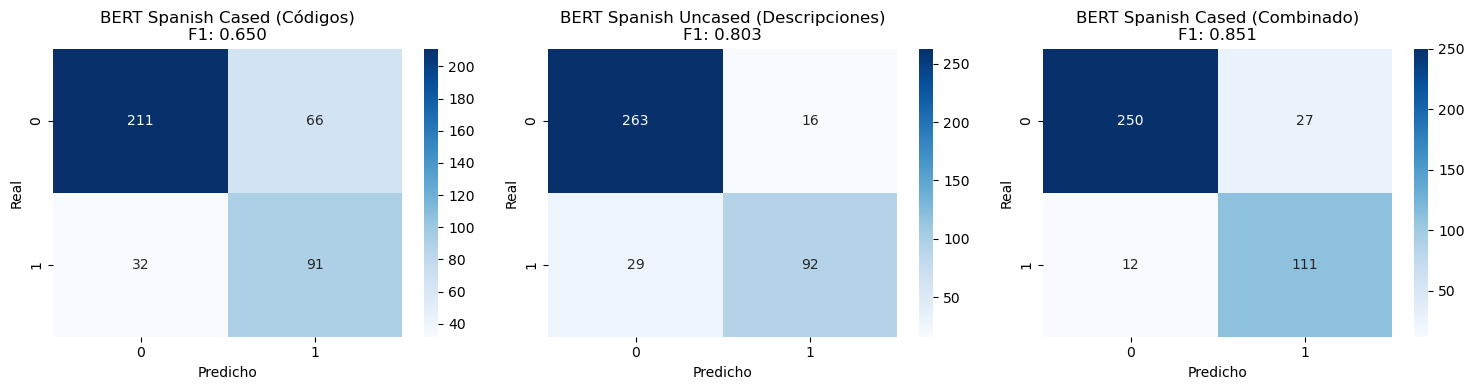

In [8]:
# Celda 8: Matrices de confusi√≥n
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (dataset_type, result) in enumerate(results.items()):
    cm = confusion_matrix(result["y_test"], result["y_pred"])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{result["name"]}\nF1: {result["metrics"]["f1"]:.3f}')
    axes[i].set_xlabel('Predicho')
    axes[i].set_ylabel('Real')

plt.tight_layout()
plt.savefig('matrices_confusion.png', dpi=300)
plt.show()

In [9]:
# Celda 9: Guardar resultados
# Guardar tabla comparativa
comparison_df.to_csv(r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\results\BERT_comparacion.csv", index=False)

# Guardar m√©tricas detalladas
detailed_results = {}
for dataset_type, result in results.items():
    detailed_results[dataset_type] = {
        "model_name": result["name"],
        "metrics": result["metrics"]
    }

import json
with open(r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\results\resultados_detallados_bert.json", "w") as f:
    json.dump(detailed_results, f, indent=2)

print("üíæ Resultados guardados:")
print("‚Ä¢ results/comparacion_mejores_modelos_bert.csv")
print("‚Ä¢ results/resultados_detallados_bert.json")

print(f"\nüéØ RESUMEN FINAL:")
print(f"Se compararon {len(results)} modelos BERT entrenados en diferentes datasets")
print(f"Cada modelo fue evaluado en su dataset correspondiente")
best_f1_model = comparison_df.loc[comparison_df['F1-Score'].idxmax()]
print(f"Mejor modelo general (F1-Score): {best_f1_model['Modelo']} - {best_f1_model['F1-Score']:.4f}")

üíæ Resultados guardados:
‚Ä¢ results/comparacion_mejores_modelos_bert.csv
‚Ä¢ results/resultados_detallados_bert.json

üéØ RESUMEN FINAL:
Se compararon 3 modelos BERT entrenados en diferentes datasets
Cada modelo fue evaluado en su dataset correspondiente
Mejor modelo general (F1-Score): BERT Spanish Cased (Combinado) - 0.8506
